[View in Colaboratory](https://colab.research.google.com/github/liannesr/Lab-6-Machine-Learning/blob/master/Lianne_S%C3%A1nchez_Lab_6_Creating_Validation_Data.ipynb)

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 6: Creating Validation Data
* Generate a training and validation data set for housing data that we will use to predict the median housing price, at the granularity of city blocks.
* Debug issues in the creation of the training and validation splits.
* Select the best single feature to use to train a linear model to predict the median housing price.
* Test that the prediction loss on the validation data accurately reflects the trained model's loss on unseen test data.

### Imports
In this first cell, we import the libraries that we will be using.

In [0]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Data Set
The lab uses [this data](https://developers.google.com/machine-learning/crash-course/california-housing-data-description)  that is based on 1990 census data from California.  Let's load our data set and examine it.

In [3]:
housing_data = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00
mean,-119.56,35.63,28.59,2643.66,539.41,1429.57,501.22,3.88,207300.91
std,2.01,2.14,12.59,2179.95,421.50,1147.85,384.52,1.91,115983.76
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.79,33.93,18.00,1462.00,297.00,790.00,282.00,2.57,119400.00
50%,-118.49,34.25,29.00,2127.00,434.00,1167.00,409.00,3.54,180400.00
75%,-118.00,37.72,37.00,3151.25,648.25,1721.00,605.25,4.77,265000.00
max,-114.31,41.95,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500001.00


##Prepare Features

As our learning models get more sophisticated, we will want to do some computation on the features and even generate new features from the existing features. For now this method will just make a copy of the portion of the dataframe we plan to use, and re-scale the median-house value (to make it a bit easier to work with).

In [0]:
def prepare_features(dataframe):
  """Prepares the features for the provided dataset.

  Args:
    dataframe: A Pandas DataFrame containing the data set.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000. This will make it a bit easier to work with.
  processed_features["median_house_value"] /= 1000.0
  
  return processed_features

##Divide the provided data for training our model into a training and validation set

Our goal for training a model is to make predictions on new unseen data.  As the model gets larger (in terms of the number of weights we are learning), it is possible to start memorizing the training data and overfitting noise that might be in that data.  When overfitting occurs our model will make poor predictions on new data, which defeats our purpose.  Thus we need a mechanism to recongize when overfitting occurs.  A common way todo this is to set aside some of the training data as a validation set using the rest as our training set.

For the ***training set***, we'll choose the first 14000 examples, out of the total of 17000.

In [5]:
training_examples = prepare_features(housing_data.head(14000))
training_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00
mean,-118.94,35.08,27.29,2687.32,548.91,1481.23,509.14,3.84,199.29
std,1.64,1.91,12.03,2266.84,435.62,1198.27,395.74,1.86,111.05
min,-122.04,32.54,1.00,2.00,2.00,3.00,2.00,0.50,15.00
25%,-120.41,33.87,17.00,1465.00,300.00,813.00,284.00,2.55,117.40
50%,-118.31,34.10,27.00,2142.00,439.00,1206.00,414.00,3.52,173.70
75%,-117.90,36.81,36.00,3187.00,658.00,1784.00,611.00,4.73,250.00
max,-114.31,41.86,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500.00


For the ***validation set***, we'll choose the last 3000 examples, out of the total of 17000.

In [6]:
validation_examples = prepare_features(housing_data.tail(3000))
validation_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,-122.44,38.18,34.65,2439.94,495.08,1188.53,464.28,4.07,244.69
std,0.43,0.95,13.32,1702.88,344.74,833.83,324.63,2.09,130.34
min,-124.35,36.87,2.00,8.00,1.00,8.00,1.00,0.50,15.00
25%,-122.49,37.71,24.00,1445.75,284.00,696.75,269.00,2.66,138.40
50%,-122.32,37.81,35.00,2080.00,412.00,1003.00,386.00,3.68,225.10
75%,-122.19,38.29,47.00,2976.50,606.25,1454.25,567.00,4.94,335.00
max,-122.04,41.95,52.00,18634.00,3618.00,8276.00,3589.00,15.00,500.00


### Examine the data

Let's take a close look at two features in particular: **`latitude`** and **`longitude`**. These are geographical coordinates of the city block in question.

This might make a nice visualization — let's plot `latitude` and `longitude`, and use color to show the `median_house_value`.

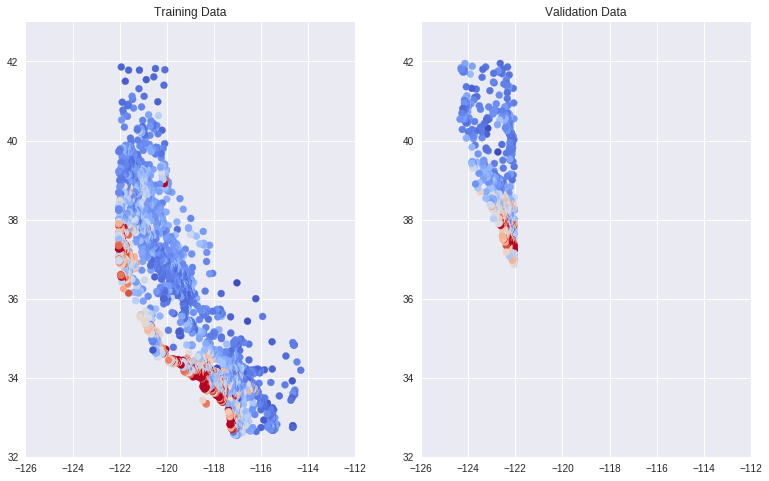

In [7]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_examples["median_house_value"] / training_examples["median_house_value"].max())

ax = plt.subplot(1, 2, 2)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_examples["median_house_value"] / validation_examples["median_house_value"].max())

_ = plt.plot()

###Setting Up the Feature Columns

We define `construct_feature_columns` to define feature columns for the features, that are all numerical for this data set.

In [0]:
NUMERICAL_FEATURES = ["longitude", "latitude", "housing_median_age",
                      "total_rooms", "total_bedrooms","population",
                      "households",	"median_income", "median_house_value"]

def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(feature)
              for feature in NUMERICAL_FEATURES])

### Input Function
We'll continue to use this same input function. You do not need to change this but if you want more detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Define Input Functions Using the Training Data and Using the Validation Data

We can now use a lambda function to create an input function to use when training the model, and one to use when evaluating the model's loss on the training data and also on the validation data.

In [0]:
NUMERICAL_FEATURES = ["households"]
LABEL = "median_house_value"

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

# Here we define an input function that will compute the loss over the entire
# validation set.
predict_validation_input_fn = lambda: input_fn(
    validation_examples[NUMERICAL_FEATURES], validation_examples[LABEL], 
    num_epochs=1, shuffle=False)

### Computing the Loss
We again use RMSE for our loss since that is the appropriate loss to use for linear regression.  However, to keep the procedure to train the model very generic, we will use a method to compute loss that can be tailored to other types of problems.


In [0]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

###Learning Curve

Similar to the last lab we define a function to plot the  **learning curve** that shows the loss being minimized on the y-axis and the training steps (time) on the x-axis.  This time we will also add the loss on the validation data to the learning curve so that you can see the training loss and validation loss.

In [0]:
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

###Visualizing Our Model Via a Calibration Plot

As in the last lab, we will use a calibration plot to visualize the model.  The x-axis is the predicted target  and the y-axis is the true target. Observe that a model with an RMSE of 0 would have all points on the line target = prediction (shown in the plot).  For points that are under the line, we are overpredicting and points over the line we are underpredicting. 

In [0]:
def calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

###Configure the LinearRegressor

As in the past labs we provide a method to define our linear regression model. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD).   We again apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm` to ensure that the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    A linear regressor created with the given parameters
  """
  
  optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_regressor

###Train the Model

We slightly modify our method to train the model to also take as input the validation features and validation labels so that we can compute the validation loss and add it to our learning curve.

In [0]:
# Function to train any linear model using a calibration plot to help visualize
# the final model

def train_model(linear_regressor, training_features, training_labels,
                validation_features, validation_labels, steps, batch_size):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    training_features: The input features from the training data
    training_labels: the labels from the training data
    validatin_features: The input features from the validation data
    validation_labels: the labels from the validation data
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn, predict_training_input_fn, and
  # predict_validation_input_fn
  training_input_fn = lambda: input_fn(training_features, training_labels,
                                       batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(training_features,
                                               training_labels,
                                               num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: input_fn(validation_features,
                                                 validation_labels,
                                                 num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print ("Training model...")
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

    # Use the predict method to compute the training loss
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    training_loss = compute_loss(predictions, training_labels)
    training_losses.append(training_loss) 
    
    # Use the predict method to compute the validation loss
    predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    validation_loss = compute_loss(predictions, validation_labels)
    validation_losses.append(validation_loss) 
    print ("  Training loss, Validation loss after period %02d : %0.3f, %0.3f" % \
      (period, training_loss, validation_loss))
      
  # Now that training is done print the final training and validation loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % training_loss) 
  print("Final Loss (RMSE) on the validation data: %0.3f" % validation_loss) 
  
  # Generate a figure with the learning curve on the left and a calibration
  # plot on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses, validation_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
  plt.title("Calibration Plot on Validation Data")
  calibration_plot(predictions, validation_labels)
   
  return linear_regressor

## Exercise: Train a Model (1 point)

Pick the single feature that you think would lead to the best model to predict the `median_house_value`. Adjust the learning_rate and steps to train a good model.  HINT: you should be able to get the RMSE to under 85.  Using `households` is not a good choice! Look at what other features are available.

Training model...
  Training loss, Validation loss after period 00 : 178.324, 223.509
  Training loss, Validation loss after period 01 : 132.332, 172.796
  Training loss, Validation loss after period 02 : 97.515, 131.075
  Training loss, Validation loss after period 03 : 84.908, 111.736
  Training loss, Validation loss after period 04 : 82.146, 105.161
  Training loss, Validation loss after period 05 : 81.723, 103.728
  Training loss, Validation loss after period 06 : 81.413, 102.401
  Training loss, Validation loss after period 07 : 81.382, 102.466
  Training loss, Validation loss after period 08 : 81.432, 102.934
  Training loss, Validation loss after period 09 : 81.317, 102.462
Final Loss (RMSE) on the training data: 81.317
Final Loss (RMSE) on the validation data: 102.462


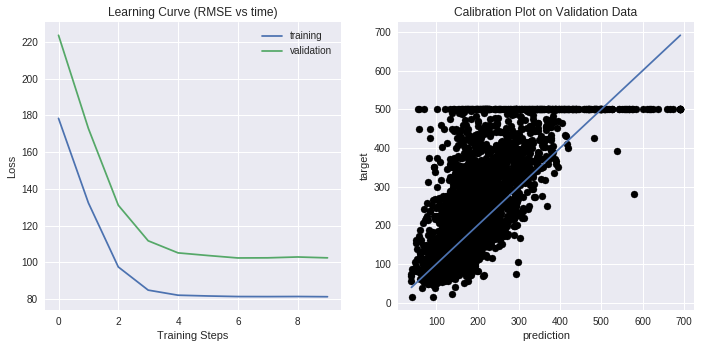

In [16]:
NUMERICAL_FEATURES = ["median_income"]
LABEL = "median_house_value"

LEARNING_RATE = 0.0025
STEPS = 10000
BATCH_SIZE = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], validation_examples[NUMERICAL_FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

## Exercise: Recognize the Problem in the Splitting of the Data (1/2 point)
As you look at the performance on the training and validation data, you are probably seeing a difference that is more than you'd expect just from the variations caused by SGD.  Let's try to figure out what is causing this.  Look back at the visualization of the data.  You should see something that resembles a map of California, with red showing up in expensive areas like the San Francisco and Los Angeles. The training set sort of does, but the validation data does not.  Answer the following questions directly in the comment area of the codebox below.

In [17]:
"""
A) Do you see any other differences in the distributions of features or targets
   between the training and validation data?
   Answer: The distributions of features and the target are very different. In 
   the training data, we can observe a plot where it shows a part of California,
   where the red dots mark very expensive places to live. When we compare this
   to the validation data we see, that it shows another part of California (not 
   the same area of California). None 
   of the data sets have the whole part of California which makes the training
   data very different and not relatable to the validation data. 
  
B) Why is this happening?
  Answer: This is happening because the data for the training is not being
  representative of the California State. The data set is a California's census,
  for there to be an effective training the training data and validation data 
  needs to be an accurate representation of California. If the training set only
  has chunks of California, the the model will train for these chunks and when given
  new data, it will predict badly. 
  
C) How is this problem reflected when you look at the relationship between the
   training loss and validation loss and why is that a concern?
   Answer: When looking at the relationship between the losses, we can observe 
   that the model is overfitting to the data in the training set. This is a 
   concern because it means that our model is not generalizing well, thus
   defeating the purpose of having a machine learning model which its goal is to 
   generalize and not memorize.
"""

"\nA) Do you see any other differences in the distributions of features or targets\n   between the training and validation data?\n   Answer: The distributions of features and the target are very different. In \n   the training data, we can observe a plot where it shows a part of California,\n   where the red dots mark very expensive places to live. When we compare this\n   to the validation data we see, that it shows another part of California (not \n   the same area of California). None \n   of the data sets have the whole part of California which makes the training\n   data very different and not relatable to the validation data. \n  \nB) Why is this happening?\n  Answer: This is happening because the data for the training is not being\n  representative of the California State. The data set is a California's census,\n  for there to be an effective training the training data and validation data \n  needs to be an accurate representation of California. If the training set only\n  has c

## Exercise: Fix the Problem (1/2 point)

Make the changes here to how the training and validation examples are created and call prepare features again.


In [0]:
## Add what you need to this code block to fix the issue you have seen ##

housing_data = housing_data.reindex(np.random.permutation(housing_data.index))
## Regenerate the training and validation examples -- put your changes here

training_examples = prepare_features(housing_data.head(14000))
validation_examples = prepare_features(housing_data.tail(3000))

Here we again view the map view of the data to confirm if the issue has been resolved.  Does this look different than above?  If not, you still have not fixed the issue.  It should be very clear once you have.

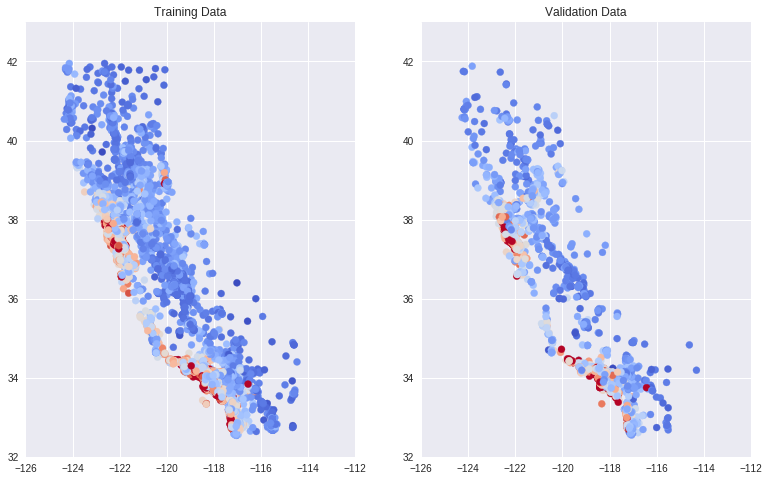

In [19]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_examples["median_house_value"] / training_examples["median_house_value"].max())

ax = plt.subplot(1, 2, 2)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_examples["median_house_value"] / validation_examples["median_house_value"].max())

_ = plt.plot()


## Exercise: Re-train a Model (1 point) 

You may need to adjust your hyperparameter but use the same feature as you selected above.

Training model...
  Training loss, Validation loss after period 00 : 196.967, 196.664
  Training loss, Validation loss after period 01 : 158.209, 158.200
  Training loss, Validation loss after period 02 : 123.173, 123.596
  Training loss, Validation loss after period 03 : 96.022, 97.061
  Training loss, Validation loss after period 04 : 84.839, 86.447
  Training loss, Validation loss after period 05 : 84.491, 86.152
  Training loss, Validation loss after period 06 : 84.390, 86.013
  Training loss, Validation loss after period 07 : 84.275, 85.870
  Training loss, Validation loss after period 08 : 84.199, 85.797
  Training loss, Validation loss after period 09 : 84.132, 85.709
Final Loss (RMSE) on the training data: 84.132
Final Loss (RMSE) on the validation data: 85.709


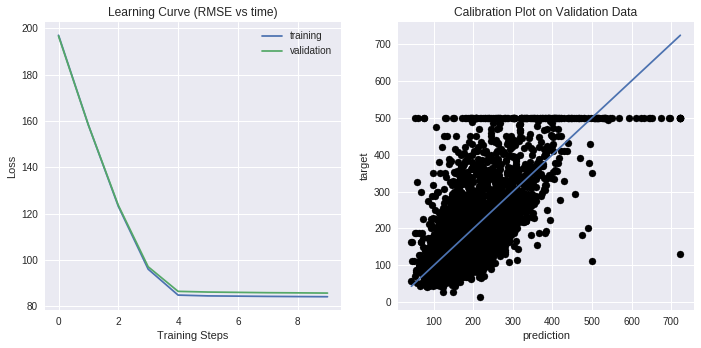

In [20]:
NUMERICAL_FEATURES = ["median_income"]
LABEL = "median_house_value"

LEARNING_RATE = 0.02
STEPS = 1000
BATCH_SIZE = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], validation_examples[NUMERICAL_FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

### Load the Provided Test Data

This data set (as with many) comes with a provided test data set that is representative and is used to evaluate the final performance. For this data set, the provided test data is located [here](https://storage.googleapis.com/ml_universities/california_housing_test.csv). The purpose of having validation data is to notice overfitting and other problems. Remember our key goal is to train a model that will make good predictions on **new unseen data**. The test data should only be used at the end to see how your final model is performing.  It should not be used in helping select which features to use or to select hyperparameter values.

In [0]:
housing_test_data = pd.read_csv(
    "https://storage.googleapis.com/ml_universities/california_housing_test.csv",
    sep=",")

test_examples = prepare_features(housing_test_data)

## Exercise: Measure the Test Error (1 point)

Modify the codebox below to measure the test error, and then answer the question below.

In [26]:
# Here we define an input function that will compute the loss over the entire
# training set.
features = test_examples[NUMERICAL_FEATURES]
targets = test_examples[LABEL]
predict_test_input_fn = lambda: input_fn(features, targets, num_epochs=1,
                                         shuffle=False)
# Fill in the rest to complete this.

# Use the predict method to compute the training loss
predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])
testing_loss = compute_loss(predictions, targets)
print("Final Loss (RMSE) on the test data: %0.3f" % testing_loss) 


Final Loss (RMSE) on the test data: 84.671


In [23]:
"""
How do the training error, validation error and test error compare to each
other?  Is this what you'd expect?

ANSWER:

In this case the training data performed a lower RMSE with 84.132, then the testing
RMSE followed with a value of 84.671 and with a final spot the validation data 
with an RMSE of 85.709. I expected the the testing error and the validation error
to be pretty close and not so far apart. Also, I expected the testing error to be 
just a but higher than the validation error. But the results make sense, since our model
is supposed to generalize better, our testing error should be better and lower than
the one used for validation.
"""

"\nHow do the training error, validation error and test error compare to each\nother?  Is this what you'd expect?\n\nANSWER:\n"